In [1]:
#pip install -r requirements.txt 

# 2023 Hackathon - Image Classification using CNN
* <b> Author: </b> Hamzah Abdulrazzaq, Erika Hall, Shankara Abbineni 
* <b> Date: </b> September 22nd, 2023
* <b> Objective: 
   </b> For this hackathon, we are focused on Convolutional Neural Networks (CNNs), with a special emphasis on a unique dataset sourced from NASA. We will be utilizing the "Mars surface image (Curiosity rover) labeled data set" which consists of 6691 images spanning 24 classes that were collected by the Mars Science Laboratory (MSL, Curosity) rover by three instruments (Mastcam Right eye, Mastcam Left eye, and MAHLI). The classes in the data set include wheel, drill, horizon, ground, rover rear deck, etc. The primary objective is to construct a CNN model that can accurately predict the classes of these images. Given that the dataset contains 24 classes, this is not an easy task. Criteria for winning submissions is determined by F1 score. The starter notebook provided here offers initial steps, helper functions, and documentation to help you succeed. While the notebook lays the groundwork, the onus is on participants to explore, innovate, and refine their models to meet the desired outcomes. 



## Table of Contents

- [Background Information: Convolutional Neural Nets](#Background-Information:-Convolutional-Neural-Nets)
- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Config Class + Basic Visualization](#Config-Class-+-Basic-Visualization)
- [Data Imbalance](#Data-Imbalance)
- [OpenCV](#OpenCV)
- [Helper Functions](#Helper-Functions)
- [Custom Image Dataset](#Custom-Image-Dataset)
- [Image Augmentation](#Image-Augmentation)
- [Size of Convolution Output](#Size-of-Convolution-Output)
- [Visualize Loss and Accuracy](#Visualize-Loss-and-Accuracy)
- [Test Model on Test Set](#Test-Model-on-Test-Set)
- [Visualize Sample Predictions](#Visualize-Sample-Predictions)
- [Submit Score](#Submit-Score)

#### For reference, <a href="resources.pdf">here</a> are the preliminary training materials that were provided prior to the event

## Background Information: Convolutional Neural Nets

A convolutional neural network (CNN or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They have proven to be very effective in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, brain-computer interfaces, and financial time series modeling. 

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. Typical ways of regularization include adding some form of magnitude measurement of weights to the loss function. CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field. (Wikipedia)

Check out this [Interactive Demo for Image Kernels](https://deeplizard.com/resource/pavq7noze2) to see a visual demo on how different types of convolutional filters are applied to an image.

<img src="https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196" style="width: 400px;">
<br>

A typical CNN architecure consists of:
- **Input Layer** – as you might expect, this layer contains the input image or sequence of images. In this layer, the number of neurons equals the number of features (which is the number of pixels in image data). 
- **Convolutional Layer(s)** – this layer applies filters or ‘kernels’ to your image. These filters are smaller than your image size. A filter crosses your image in ‘strides’, and after each stride the model returns a value denoting how closely the portion of the image matches the filter.  [What are Convolutional Neural Networks (CNN)?](https://www.bing.com/videos/search?q=convolutional+neural+network&docid=603549927117705930&mid=E7ED04059A9474B24BFEE7ED04059A9474B24BFE&view=detail&FORM=VIRE) is a short video that gives a great visual illustration of this concept. 
- **Pooling Layer(s)** – this layer’s job is to reduce the size, which makes the model faster and combats overfitting. This layer summarizes each filter-sized portion of the image. In other words, for a group of features or pixels, the pooling layer returns a single feature that represents the group. Two common approaches to pooling are (1) average pooling, where the layer returns an average of the features and (2) max pooling, where the layer returns the maximum-valued feature. Geeks for Geeks goes into further detail on how pooling layers work and how to implement them in [CNN | Introduction to Pooling Layer](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/). 
- **Fully Connected Layer(s)** – this layer computes the final task. 
- **Output Layer** – this layer takes the final calculation and converts it to a probability score for each class.   



<img src="https://lh3.googleusercontent.com/yrHzday2CwSYLkXf9yKSoH-BpjqnnAuyiMvPAS5yS3-lFnl5jwkR6FoT_v2Vbi14s414fJSORuGLRQbHyYp6dtHDItRcSQnRWcd1JRGbZC5VlGTvH80gFZrHw8qg2Tx7ca2HYKFc" style="width: 600px;">


# Importing Necessary Libraries

In [2]:
import torch   
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
from torchvision.transforms import transforms
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout2d, BatchNorm2d
from torchvision.datasets import ImageFolder
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

plt.style.use('seaborn')

/tmp/ipykernel_3296/1349311401.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/train_data_uprm.csv') # read in training data
val_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/val_data_uprm.csv') # read in validation data
test_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/test_data_uprm.csv') # read in testing data.  
# reported score will be based on model performance on test data

In [5]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## Config Class + Basic Visualization

#### Note: The config class is often used to centralize various settings and parameters. For our purposes, we will be using it to make sure all of our configuration settings are in one place

In [6]:
class Config: 
    img_dimensions = (128, 128)
    channels = 3 # number of channels in each image (RGB)
    images_path = '/domino/datasets/UPRM_Hackathon_2023'

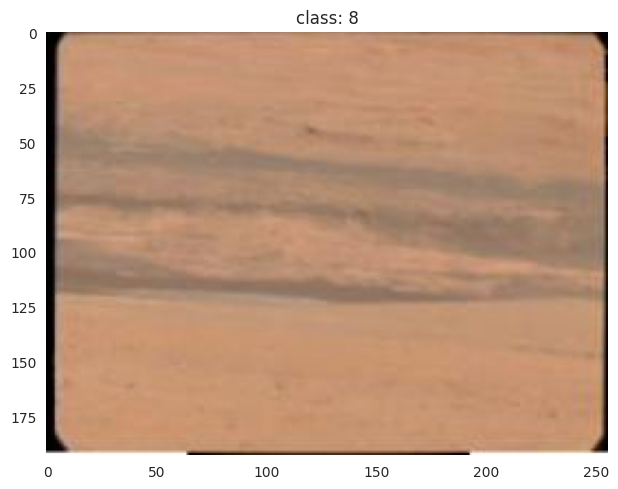

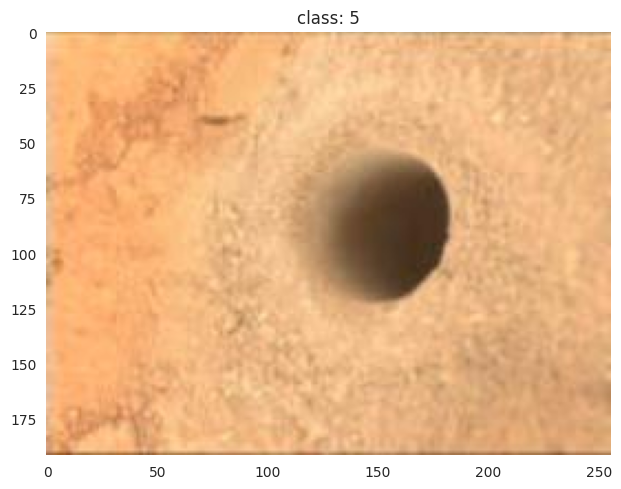

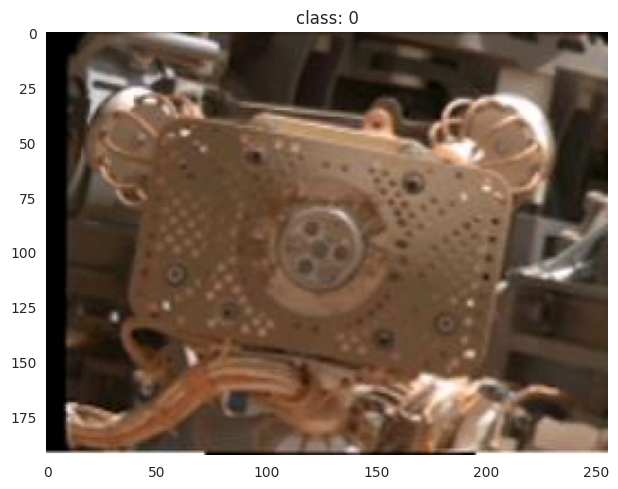

In [7]:
def img_display(path, label):
    read_image = cv2.imread(path)[:,:,::-1]
    plt.imshow(read_image)
    plt.grid(False)
    plt.title(f'class: {label}')
    plt.show()

train_images = [os.path.join(Config.images_path, i) for i in train_data_raw['image']]
train_labels = [i for i in train_data_raw['label']]

val_images = [os.path.join(Config.images_path, i) for i in val_data_raw['image']]
val_labels = [i for i in val_data_raw['label']]

test_images = [os.path.join(Config.images_path, i) for i in test_data_raw['image']]
test_labels = [i for i in test_data_raw['label']]

img_display(train_images[2], train_labels[2])
img_display(val_images[5], val_labels[5])
img_display(test_images[3], test_labels[3])

## Data Imbalance

#### $\hspace{3mm}$ i. Defintion

$\hspace{6mm}$ An imbalanced dataset is simply a dataset where the class proportions are skewed. Below is a plot showing the data imbalance in our dataset.

<Axes: >

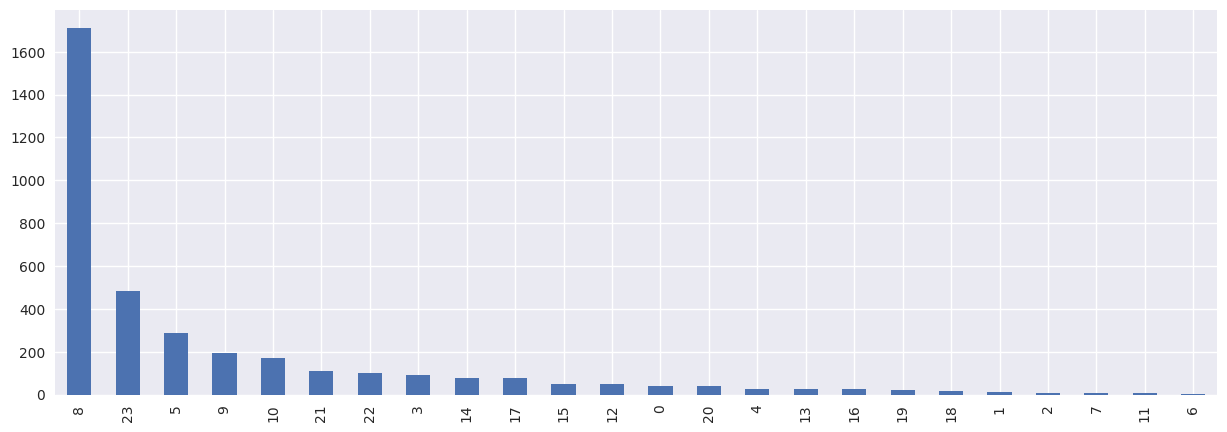

In [8]:
figure = plt.figure(figsize=(15,5))
train_data_raw['label'].value_counts().plot(kind='bar')

#### $\hspace{3mm}$ ii. Strategies for handling it 

$\hspace{6mm}$There are quite a few approaches to choose from to combat imbalanced datasets: 
> 1. Oversampling and undersampling
3. Image augmentation
4. Including weights for each class in a loss function

$\hspace{12mm}$and many more!

 

$\hspace{6mm}$ You can refer to the pretraining materials for details on how to implement these strategies!

# OpenCV

#### $\hspace{3mm}$ i. Definition

> OpenCV is an open source library for C++, Python, and Java that can be used to process images or videos. In our case, we will use OpenCV to prepare a set of images for model ingestion. [OpenCV – Overview](https://www.geeksforgeeks.org/opencv-overview/) has lots more detail on the specific capabilities of OpenCV if you’re interested in delving deeper into this library.

 

#### $\hspace{3mm}$ ii. Important operations
> In this workbook, the most important OpenCV operations will be the ***basic image operations*** and the ***image augmentation operations***. Feel free to refer to your pretraining materials for details and examples demonstrating how to implement them!

<a href="open_cv_exploration_example.ipynb">This notebook</a> implements some OpenCV functions on our current dataset. Feel free to pull from these image augmentation examples to experiment with other image augmentation technqies!  

## **Note**

> if you would like to apply a particular OpenCV function to your input data, please do so inside the <code>resize_normalize</code> function below. A commented out example is available for reference inside the function. The <code>resize_normalize</code> function is then used inside the <code>CustomImageDataset</code> class.

## Helper Functions

In [9]:
def resize_normalize(img):
    """
    Argument: image
    steps: 1. Resize image to specified dimensions
           2. transpose so that channels are first
           3. resize image
    """
    img = cv2.resize(img, Config.img_dimensions)
    
    #ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    img = np.transpose(img, (2,0,1)) # reorder it to channels first
    img = torch.from_numpy(img).float()
    img = img / 255
    
    
    
    return img

In [10]:
def to_numpy(x):
    return x.detach().cpu().numpy()

### Balance the data using oversampling + undersampling

In [11]:
from sklearn.utils import resample, shuffle

TARGET_COUNT = 260


# Balance the data in order to reduce overfitting on a category
def balance_data(df, target_count=TARGET_COUNT):
    # Filter out non-existing images
    valid_rows = []
    for idx, row in df.iterrows():
        img_path = os.path.join(Config.images_path, row['image'])
        if os.path.exists(img_path):
            valid_rows.append(row)
        else:
            print(f"File not found: {img_path}")

    df = pd.DataFrame(valid_rows).reset_index(drop=True)  # Reset index to avoid mismatch
    
    # Separate the dataframe by classes
    classes = df['label'].unique()
    balanced_dfs = []

    for cls in classes:
        cls_df = df[df['label'] == cls]
        
        # Undersample if the class count is greater than the target
        if len(cls_df) > target_count:
            cls_df = resample(cls_df, replace=False, n_samples=target_count, random_state=42)
        
        # Oversample if the class count is smaller than the target
        elif len(cls_df) < target_count:
            n_samples_to_add = target_count - len(cls_df)
            extra_samples = resample(cls_df, replace=True, n_samples=n_samples_to_add, random_state=42)
            extra_samples['is_duplicate'] = True  # Mark them as duplicates, in order to identify later when creating custom dataset
            cls_df['is_duplicate'] = False  # Mark original samples as not duplicates
            cls_df = pd.concat([cls_df, extra_samples])
        
        balanced_dfs.append(cls_df)
        
    # Concatenate the balanced dataframes
    balanced_data = pd.concat(balanced_dfs, ignore_index=True)
    balanced_data = shuffle(balanced_data)
    
    return balanced_data


File not found: /domino/datasets/UPRM_Hackathon_2023/0003ML0000000120100032I01_DRCL.JPG
File not found: /domino/datasets/UPRM_Hackathon_2023/0003ML0000000110100031I01_DRCL.JPG
File not found: /domino/datasets/UPRM_Hackathon_2023/0003ML0000000110100031E01_DRCL.JPG


<Axes: >

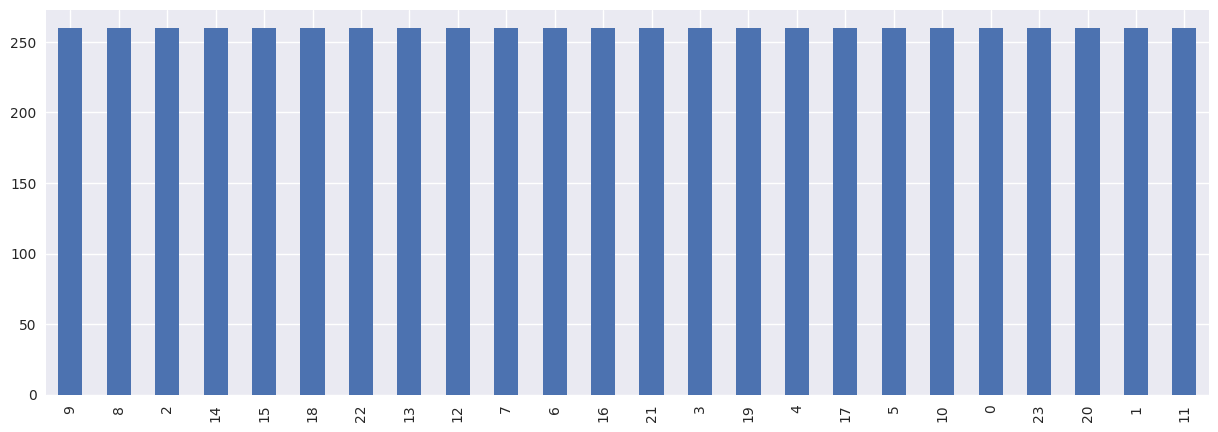

In [12]:
train_data_raw = balance_data(train_data_raw, target_count=TARGET_COUNT)

#Display new data plot
figure = plt.figure(figsize=(15,5))
train_data_raw['label'].value_counts().plot(kind='bar')

##  

## Custom Image Dataset 

### Using the Dataset primitive to create a custom image dataset 

We created our own custom image dataset for this Hackathon, using images from a NASA post on [data.gov](https://www.geeksforgeeks.org/opencv-overview/). You can also find the image files on [Zenodo](https://zenodo.org/record/1049137). 

For a better understanding of the <code>CustomImageDataset</code> code provided, refer to the pretraining materials or check out [the official documetation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) on *how* to create your own image dataset using pytorch.

##### ** Note: A basic Custom Image Dataset is set up below for you to use, but feel free to experiment and create your own! **


In [13]:
from torchvision.io import read_image
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        # Filter out non-existing images
        valid_rows = []
        for idx, row in dataset.iterrows():
            img_path = os.path.join(Config.images_path, row['image'])
            if os.path.exists(img_path):
                valid_rows.append(row)
                #Now, duplicate that path if needed for oversampling 
            else:
                print(f"File not found: {img_path}")
                
       
            
        self.dataset = pd.DataFrame(valid_rows).reset_index(drop=True)  # Reset index in order to not mismatch
        self.image_labels = list(self.dataset['label'])
        self.image_path = list(self.dataset['image'])
        self.img_dir = Config.images_path
        
        self.transform = transform
        self.target_transform = target_transform
        
        if 'is_duplicate' not in self.dataset.columns:
            self.dataset['is_duplicate'] = False
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset.loc[idx, 'image'])
        image = cv2.imread(img_path)
        label = self.dataset.loc[idx, 'label']
        is_duplicate = self.dataset.loc[idx, 'is_duplicate']

        image = resize_normalize(image)  # Assuming resize_normalize is defined elsewhere

        if is_duplicate and self.transform:  # Apply augmentation only to duplicates
            #print("applying transform to duplicate image")   
            #plot before the transfrom
            # plt_img = np.transpose(image, (1, 2, 0))
            # plt.imshow( plt_img )
            # plt.grid(False)
            # plt.title(f'class: {label}')
            # plt.show()
            
            #transform it
            image = self.transform(image)
            
            #plot that image
            # plt_img = np.transpose(image, (1, 2, 0))
            # plt.imshow( plt_img )
            # plt.grid(False)
            # plt.title(f'class: {label}')
            # plt.show()
            
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Image Augmentation


The <code>transforms</code> function can be used to augment images for better training results. 
Some augmentation methods that can be passed to <code>transforms</code> include horizontal flip, vertical flip, random crop, etc. Official documentation can be found [here](https://pytorch.org/vision/stable/transforms.html), and deeper explanation can be found in the pretraining resources.

<a href="data_augmentation_example.ipynb"> Here</a> is a workbook that provides examples of how to use <code>transforms</code> to augment our image data.

In [14]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.ToTensor()
    ])

train_ds = CustomImageDataset(train_data_raw, transform=transform)
valid_ds = CustomImageDataset(val_data_raw)


File not found: /domino/datasets/UPRM_Hackathon_2023/0003ML0000000120100032E01_DRCL.JPG


## Size of Convolution Output

Each layer of our CNN Model below yields a uniquely-sized output. If you would like to see how to use this equation to calculate a layer's output size, refer to the pretraining resources: 

$$ OutputSize = \lfloor{\frac{n+2(padding)-kernel}{stride}}\rfloor + 1 $$

If you alter the model's architecture, this equation may be helpful for understanding how your new model works!

### Note: Below is a basic CNN architecture to help you get started. You will need add additional layers and customizations to get the desired model performance.

In [15]:
class CNN_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.drop = Dropout2d(0.3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # stride set to 1 by default
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(65536, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        # outputsize = 32x128x128. -> calculation: output_size = [(128+2(1)-3)/1] + 1 = 128
        x = nn.Sigmoid()(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2) # outputsize = 32x64x64
        
        
        x = self.conv2(x)# outputsize = 64x64x64
        x = nn.Sigmoid()(x)
        x = F.max_pool2d(x, 2, 2) # outputsize = 64x32x32
    
        
        x = x.view(x.size(0), -1) # flatten output -> shape: (64*32*32,1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.drop(x)
        
        
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

In [16]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
def train_model(
    CNN_model, train_ds, valid_ds, epochs, learning_rate, num_classes
):
    torch.manual_seed(39) # set seed
    model = CNN_model(num_classes) # instantiate model
    print(model) # print model architecture
    
    train_dataloader = DataLoader(
        train_ds, batch_size=32, shuffle=True
    ) # this will allow us to iterate through images in batches
    test_dataloader = DataLoader(
        valid_ds, batch_size=32, shuffle=False
    )  
    criterion = torch.nn.CrossEntropyLoss()
    # value of 0 would denote perfect model. It is also a measure of class purity. 
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    ) # In short, optimizer is used to minimize loss. We are using Adam since it tends
    # to have smaller variance and faster convergence.

    acc_hist_train = []
    acc_hist_val = []
    
    train_losses = []
    val_losses = []
    
    
    early_stopper = EarlyStopper(patience=5, min_delta=10)
    for epoch in range(1, epochs + 1): # loop over dataset many times
        #print(f'memory cleared: {torch.cuda.memory_allocated() / (1024**2):.2f} allocated')
        #torch.cuda.empty_cache()
        model.train()  # set to train mode
        running_loss = 0.0
        accuracy_hist_train = 0
        for x_batch, y_batch in tqdm(train_dataloader):
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward() # back propoagation
            optimizer.step() # updates weights
            optimizer.zero_grad() # zero out the gradients 
            running_loss += loss.item()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().float()

            
            # how many of predictions were correct?
            accuracy_hist_train += is_correct
            
        

            

        accuracy_hist_train /= len(train_dataloader.dataset)
        running_loss /= len(train_dataloader.dataset)
        # since we accu
        acc_hist_train.append(accuracy_hist_train)
        train_losses.append(running_loss)

        accuracy_hist_valid = 0
        model.eval() # disables dropout, etc
        with torch.no_grad(): # disables gradient 
            val_loss = 0.0
            running_f1_score = 0.0
            for x, y in test_dataloader:
                pred = model(x) # predict 
                is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
                loss = criterion(pred, y)
                val_loss += loss
                f1_score_calc = f1_score(to_numpy(torch.argmax(pred, dim=1)), to_numpy(y), average='macro')
                running_f1_score += f1_score_calc
                accuracy_hist_valid += is_correct
            accuracy_hist_valid /= len(test_dataloader.dataset)
            val_loss /= len(test_dataloader.dataset)
            acc_hist_val.append(accuracy_hist_valid)
            running_f1_score /= np.ceil(len(val_data_raw)/32)

        if early_stopper.early_stop(val_loss):
            print(f'Early Stop -> Epoch = {epoch}')
            break
        
        if (epoch > 1 and val_loss < np.min(val_losses)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint.pt')
        
        val_losses.append(to_numpy(val_loss))
        
        print(f"Epoch: {epoch}")
        print("Train Acc:\t{:.3f}".format(accuracy_hist_train))
        print("Val Acc:\t{:.3f}".format(accuracy_hist_valid))
        print("Train Loss: \t{:.3f}".format(running_loss))
        print("Val Loss: \t{:.3f}".format(val_loss))
        print("Val F1 Score: \t{:.3f}".format(running_f1_score))
        print("---------------------------------------------")
        
    model = CNN_model(num_classes)
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()

    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

In [25]:
data_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
for img, lbl in data_loader:
    print(img.shape, lbl.shape)
    
num_epochs = 1
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(CNN_model, train_ds, valid_ds, 
                                                  num_epochs, learning_rate=0.05, num_classes=24)

torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size

100%|██████████| 195/195 [02:11<00:00,  1.48it/s]


Epoch: 1
Train Acc:	0.041
Val Acc:	0.001
Train Loss: 	0.100
Val Loss: 	0.102
Val F1 Score: 	0.000
---------------------------------------------


## Visualize Loss and Accuracy

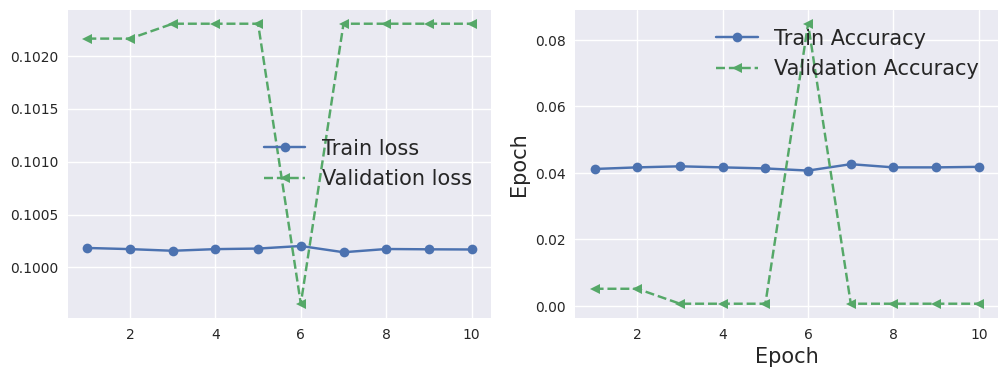

In [19]:
x_axis = np.arange(num_epochs) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(x_axis, acc_hist_val, '--<', label='Validation Accuracy')        
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

## Test Model on Test Set

In [20]:
test_ds = CustomImageDataset(test_data_raw, Config.images_path)
test_dl = DataLoader(test_ds, batch_size=32)

accuracy_test = 0.0
actual_labels = []
predicted_labels = []
with torch.no_grad():
    # disables gradient 
    val_loss = 0.0
    for x, y in test_dl:
        pred = model(x) #predict 
        is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
        accuracy_test += is_correct.mean()
        actual_labels.append(to_numpy(y))
        predicted_labels.append(to_numpy(torch.argmax(pred, dim=1)))
    accuracy_test /= len(test_dl.dataset) 
    
print(f'test accuracy: {accuracy_test}')
print(f"{bcolors.OKCYAN}{bcolors.BOLD}NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
predicted_labels = [item for sublist in predicted_labels for item in sublist]
actual_labels = [item for sublist in actual_labels for item in sublist]
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'f1_score: {F1_score}')

test accuracy: 0.05647840350866318
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
f1_score: 0.004454926624737946


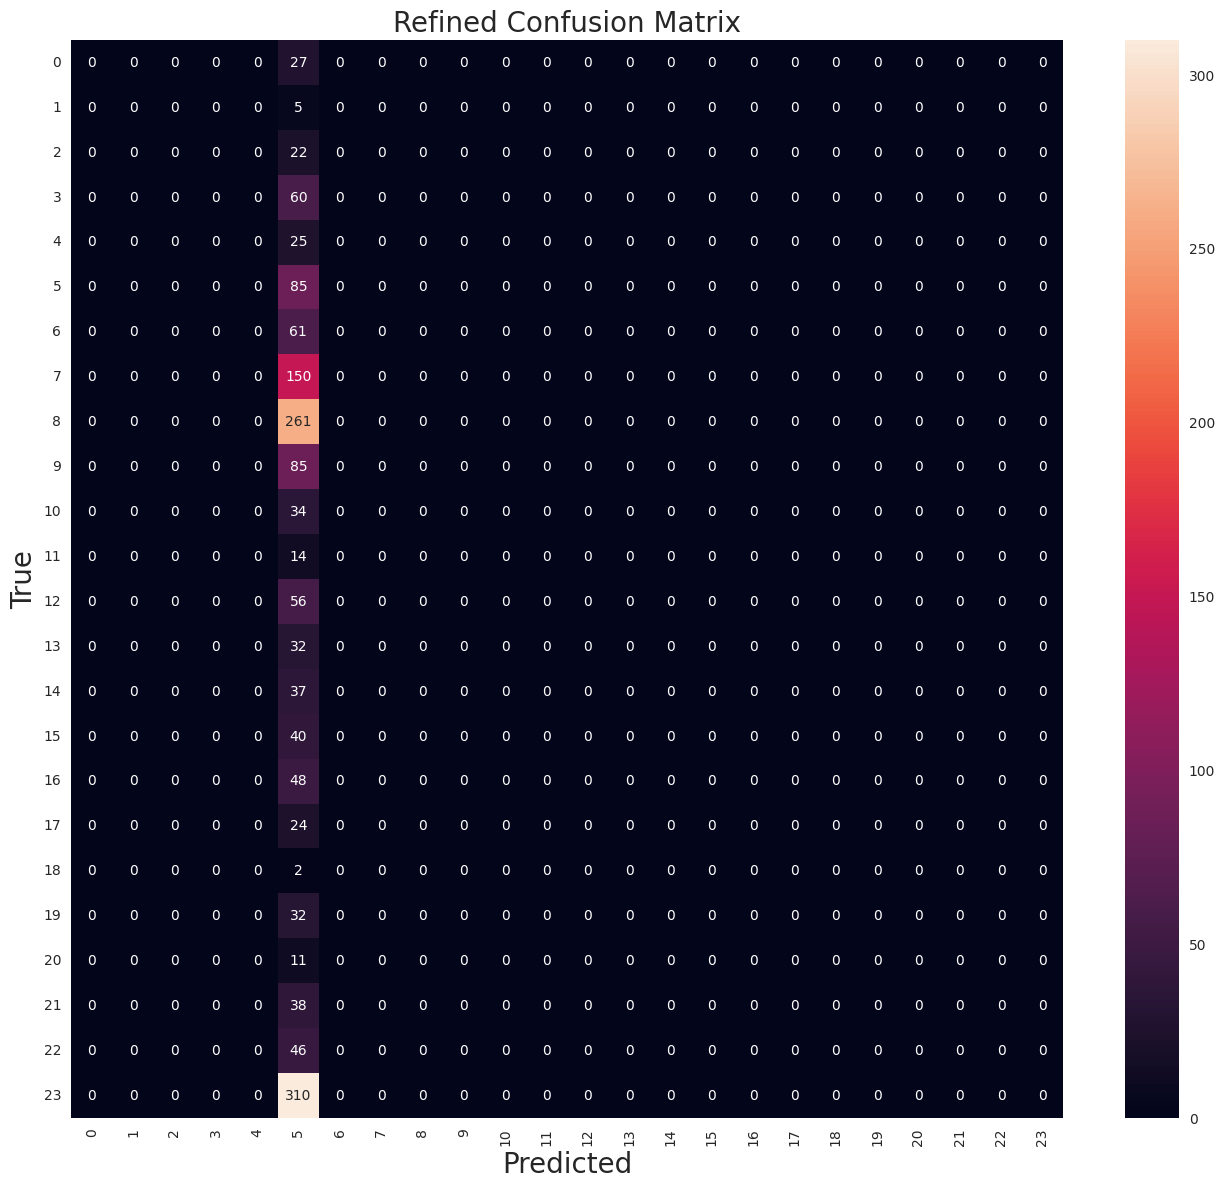

f1_score: 0.004454926624737946
Recall: Criteria for winning submissions is determined by the F1 score above!


In [21]:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = list(set(test_data_raw['label']))

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')
print(f"{bcolors.FAIL}{bcolors.BOLD}{bcolors.UNDERLINE}Recall: Criteria for winning submissions is determined by the F1 score above!")

### REMARK:  Confusion Matrix provided below is a great way to gauge where the model is underperforming. 
>  A confusion matrix is a great way to graphically visualize True Positives, False Positives, True Negatives, and False Negatives. For Example, the confusion matrix can demonstrate to you that your model is adept at distinguishing between wheel and rover rear deck, but not inept when it comes to distinguishing between portion tube and portion tube opening. 
> Several strategies you can consider based on feedback received from confusion matrix: 
 >> 1. Modify CNN architecture? 
 >> 2. Focus on Hyperparameter tuning? 
 >> 3. Visualize sample images for portion tube and portion tube opening and experiment with opencv functions that can help better distinguish between the two classes as a precossessing steps? 
 
 Above are a few suggestions for how you can tackle such a problem. Please feel free to research and experiment on your own!

## Visualize Sample Predictions

In [22]:
image, label = next(iter(test_dl)) # sample images, labels from dataset
preds = torch.argmax(model(image), dim=1) # get predictions for images

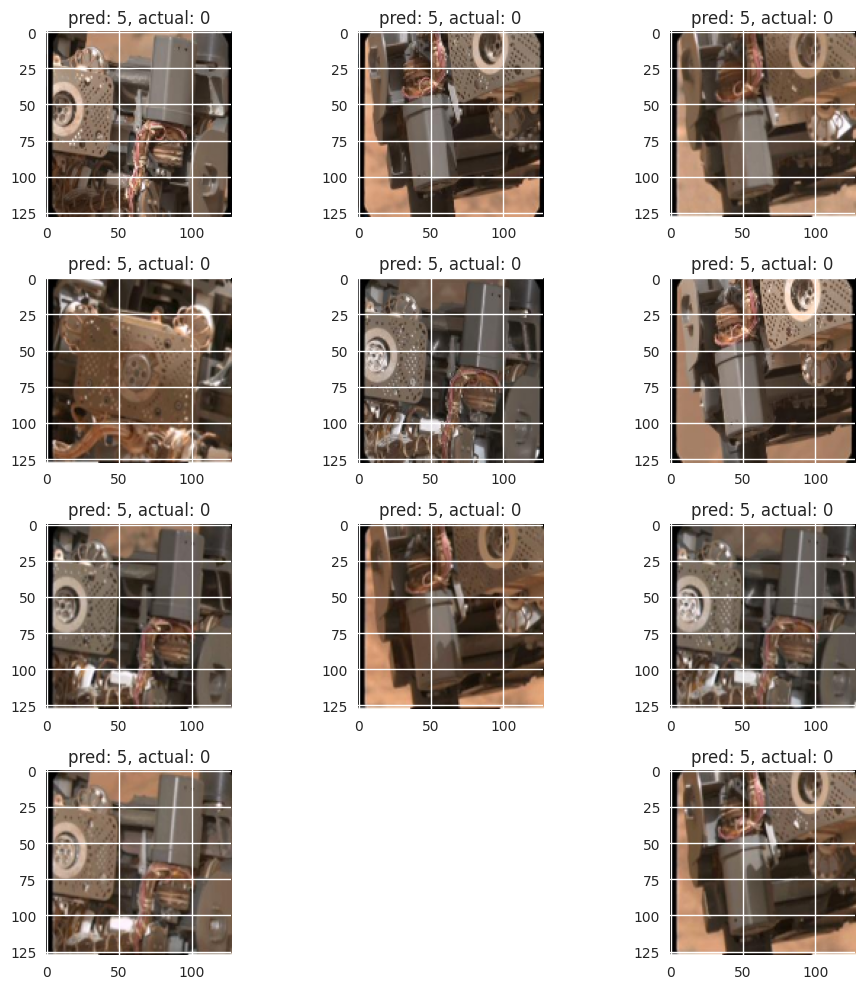

In [ ]:
# here we plot the image, its prediction, and its true label to investigate our model performance
plt.figure(figsize=(10,10))
j = 0
for img, lbl, predicted in zip(image[:12,:,:,:], label[:12], preds[:12]):
    img = to_numpy(img)
    lbl = to_numpy(lbl)
    img = np.transpose(img, (1,2,0))
    plt.subplot(4, 3, j+1)
    plt.imshow(img[:,:,::-1])
    plt.tight_layout()
    plt.title(f'pred: {predicted}, actual: {lbl}')
    j += 1

# Grading/Submission Guidelines

## Submissions
Please email your submissions to jean.han@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. F2 Score copied in with all the digits

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/24) 12PM \
> - Participants are encouraged to submit as much as they can, and we will select the one with the highest F1 score too add to the leaderboard. 
> - Winners will be announced on Sunday (9/24) 2PM. We'll have a session for winning team to provide a walkthrough of their code, their strategies on how they approached the problem and engage in a discussion.  

*Back to [top](#2023-Hackathon---Image-Classification-using-CNN)*